In [1]:
import mlfinlab as ml
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Obtain data

In [2]:
#read data
data=pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
data.tail()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2016-12-30 20:59:58.848,2236.00,2236.5,2235.75,2236.50,31334,70065316.00,1408
2016-12-30 21:00:00.352,2236.25,2237.5,2235.75,2235.75,31456,70355994.75,832
2016-12-30 21:00:24.294,2236.00,2237.0,2235.00,2236.25,31319,70029228.00,1123
2016-12-30 21:03:03.027,2236.25,2236.5,2233.75,2235.25,31346,70052618.00,1695
2016-12-30 21:13:31.990,2235.00,2236.0,2234.25,2235.00,31346,70064599.00,1869


In [3]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [4]:
data=data['2015-01-01':]
data.shape[0]


24079

Format data to include three columns of date_time,volume to minimise size of csv file and read time of file.

determine whether data is trending or mean reverting

In [5]:
result=adfuller(data['close'].values,2)
print('Augmented Dicky-Fuller test statistic: {}'.format(result[0]))
print('p-value:{}'.format(result[1]))
print('Critical Values:')
for key,value in result[4].items():
    print ('\t{}:{}'.format(key,value))

Augmented Dicky-Fuller test statistic: -1.9709872938861808
p-value:0.299437216474311
Critical Values:
	1%:-3.4306216171313206
	5%:-2.861660046345803
	10%:-2.566833897195054


According to the results for Adfuller test the test statistic is greater than any of the critical values thus the null hypothesis that the series has a unit root can not be rejected

We further examine the mean reversion tendecies of the time series by carrying out the Hurst Exponent test whereby:

* H<0.5 - The time series is mean reverting
* H=0.5 - The time series is a Geometric Brownian Motion
* H>0.5 - The time series is trending

Obtain the Hurst Exponent

In [6]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
def hurst(ts):
    
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0
# Create a Gometric Brownian Motion, Mean-Reverting

In [7]:
#Output the Hurst Exponent
print("Hurst(TR): %s" % hurst(data['close'].values))

Hurst(TR): 0.48992158709360556


The Hurst exponent is less than 0.5 hence the time series is mean reverting and thus we shall look to apply mean reverting strategies to the time series

### Fit a Primary Model:Mean Reverting on Bollinger Bands 

Define Helper Functions

In [8]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [9]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

Fit a Primary Model:Mean Reversion based on bollinger bands

In [10]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2016-06-17 13:30:04.465,2067.25,2068.75,2066.50,2067.75,33907,70112466.75,3102,2063.866867,2075.187357,2052.546377
2016-06-28 16:42:55.868,2012.25,2016.00,2011.75,2014.25,34782,70057582.50,3461,2007.470912,2021.991632,1992.950193
2016-01-07 16:18:02.956,1963.50,1965.25,1961.00,1962.50,35667,70006142.50,4423,1961.849813,1984.202125,1939.497501
2015-06-26 19:54:33.605,2092.75,2094.00,2092.00,2093.00,33449,70001643.50,3578,2095.531583,2103.904877,2087.158288
2016-04-20 16:14:22.503,2098.75,2099.00,2097.00,2097.25,33369,70016724.50,2908,2093.570172,2100.857704,2086.282640
2016-03-23 18:02:13.563,2032.50,2034.50,2031.50,2034.25,34570,70271865.25,4599,2035.738709,2042.219540,2029.257878
2016-02-11 21:00:00.156,1825.50,1826.00,1822.25,1822.25,38391,70016278.00,2252,1823.024445,1837.680112,1808.368779
2015-06-01 19:16:55.463,2116.50,2116.75,2114.50,2116.25,33169,70181414.50,3180,2109.621537,2116.812409,2102.430664
2016-03-16 16:18:42.136,2006.75,2008.50,2006.75,2008.00,34896,70054898.00,4744,2004.725570,2011.010843,1998.440297


In [11]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [12]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    1251
-1.0    1085
Name: side, dtype: int64


In [13]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [14]:
print(data.side.value_counts())

 1.0    1251
-1.0    1085
Name: side, dtype: int64


### Filter Events:CUSUM Filter

Predict what will happen when a CUSUM event is triggered.Use signal obtained from MAvg strategy to determine the side of the bet

In [15]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2015-01-01':'2015-12-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [16]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

C:\ProgramData\Anaconda3\lib\site-packages\mlfinlab\labeling\labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-12-03 10:38:03.748468 100.0% apply_pt_sl_on_t1 done after 2.5 minutes. Remaining 0.0 minutes.


In [17]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    727
-1.0    579
Name: side, dtype: int64

### Results of Primary Model:

In [18]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       571
           1       0.56      1.00      0.72       735

   micro avg       0.56      0.56      0.56      1306
   macro avg       0.28      0.50      0.36      1306
weighted avg       0.32      0.56      0.41      1306

Confusion Matrix
[[  0 571]
 [  0 735]]

Accuracy
0.5627871362940275


**A few takeaways**
* There is an imbalance in the classes - far more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [19]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2015-01-02 15:39:14.826,2055.00,2055.75,2051.25,2051.75,34093,70002159.25,11391,2059.642749,2066.077469,2053.208029,30.0,NaN
2015-01-02 15:43:25.099,2051.75,2051.75,2047.00,2047.75,34162,70005202.25,11490,2058.609174,2066.654918,2050.563430,21.0,1.0
2015-01-02 15:48:54.420,2047.75,2049.50,2045.50,2048.25,34192,70013855.25,11815,2057.749862,2066.623663,2048.876061,18.0,1.0
2015-01-02 15:57:26.907,2048.25,2051.75,2047.50,2050.50,34159,70006929.50,12459,2057.173673,2066.197362,2048.149984,31.0,1.0
2015-01-02 16:07:49.314,2050.50,2051.00,2045.50,2045.50,34208,70061993.75,13503,2056.281805,2066.177348,2046.386262,27.0,NaN


### Features

In [20]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [21]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [22]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [23]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified event dates

In [24]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2015-01-05 14:30:57.874,26.0,1.0,0.000000,0.000000,-0.002937,-0.002937,-0.003790,-0.003303,NaN,NaN,NaN,NaN,NaN,NaN,-0.002941,0.000000,-0.000856,0.000489,0.001469,-1.0
2015-01-05 14:44:56.036,29.0,1.0,-0.001474,-0.001473,-0.002574,-0.001473,-0.001473,-0.004405,NaN,NaN,NaN,NaN,NaN,NaN,-0.001104,0.001104,0.000000,-0.002941,0.000000,-1.0
2015-01-05 14:54:26.286,26.0,1.0,-0.001843,-0.001842,-0.000737,-0.002209,-0.003310,-0.002209,NaN,NaN,NaN,NaN,NaN,NaN,0.001106,-0.001474,-0.001104,0.001104,0.000000,-1.0
2015-01-05 15:01:57.494,19.0,1.0,-0.000493,-0.000493,-0.001599,-0.003438,-0.002335,-0.003805,NaN,NaN,NaN,NaN,NaN,NaN,-0.001108,-0.001843,0.001106,-0.001474,-0.001104,-1.0
2015-01-05 15:07:29.012,17.0,1.0,-0.001356,-0.001355,-0.001847,-0.002952,-0.004788,-0.003687,NaN,NaN,NaN,NaN,NaN,NaN,-0.000493,-0.001108,-0.001843,0.001106,-0.001474,-1.0


### Fit a model

In [25]:
# Split data into training, validation and test sets
X_training_validation = X['2015-01-01':'2015-12-01']
y_training_validation = y['2015-01-01':'2015-12-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2,shuffle=False)

In [26]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    256
0    213
Name: bin, dtype: int64

In [27]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 1]
minority = train_df[train_df['bin'] == 0]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    256
0    256
Name: bin, dtype: int64

In [28]:
train_df.dropna(axis=0,inplace=True)

In [29]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [30]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [31]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.53682586 0.62679561 0.69257182 0.69676159 0.7077873  0.72208921
 0.72618448 0.58858367 0.68762601 0.73991935 0.73298891 0.7468498
 0.76228579 0.76480595 0.64053049 0.73887979 0.78402218 0.77551663
 0.7843372  0.79782006 0.79945817 0.66210938 0.77718624 0.81835938
 0.81476815 0.82409274 0.82938508 0.82944808 0.68082157 0.81502016
 0.85653982 0.86176915 0.86466734 0.87254284 0.87210181]
256 7 42


In [32]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       248
           1       0.98      0.99      0.98       256

   micro avg       0.98      0.98      0.98       504
   macro avg       0.98      0.98      0.98       504
weighted avg       0.98      0.98      0.98       504

Confusion Matrix
[[242   6]
 [  2 254]]

Accuracy
0.9841269841269841


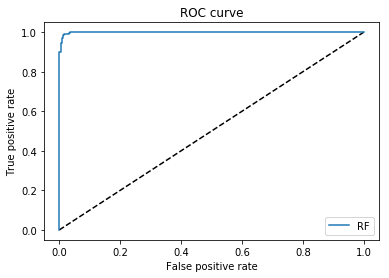

In [33]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.37      0.14      0.20        73
           1       0.31      0.62      0.41        45

   micro avg       0.32      0.32      0.32       118
   macro avg       0.34      0.38      0.31       118
weighted avg       0.35      0.32      0.28       118

Confusion Matrix
[[10 63]
 [17 28]]

Accuracy
0.3220338983050847


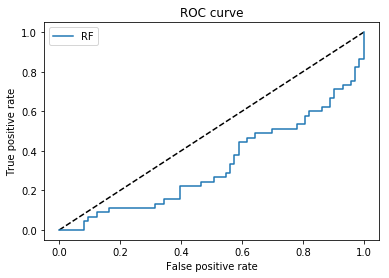

In [34]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [35]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2015-01-01 23:00:23.723')
end = primary_forecast.index.get_loc('2015-11-28 20:59:59.038') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

KeyError: '2015-01-01 23:00:23.723'

In [ ]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

---
## Performance Tear Sheets (In-sample)

In [36]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [37]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [38]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)

Start date,2015-09-29
End date,2015-12-01
Total months,2
,Backtest
Annual return,-69.1%
Cumulative returns,-19.3%
Annual volatility,47.9%
Sharpe ratio,-2.21
Calmar ratio,-2.58
Stability,0.50
Max drawdown,-26.8%


In [40]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

Start date,2015-09-29
End date,2015-12-01
Total months,2
,Backtest
Annual return,-85.7%
Cumulative returns,-29.9%
Annual volatility,45.0%
Sharpe ratio,-4.08
Calmar ratio,-2.59
Stability,0.71
Max drawdown,-33.1%


---
## Perform out-of-sample test

In [42]:
# extarct data for out-of-sample (OOS)
X_oos = X['2015-12-02':]
y_oos = y['2015-12-02':]

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       285
           1       0.58      0.66      0.62       434

   micro avg       0.51      0.51      0.51       719
   macro avg       0.46      0.47      0.46       719
weighted avg       0.49      0.51      0.49       719

Confusion Matrix
[[ 76 209]
 [146 288]]

Accuracy
0.5062586926286509


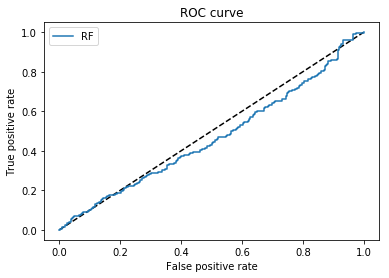

In [43]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [44]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2016-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       264
           1       0.60      1.00      0.75       396

   micro avg       0.60      0.60      0.60       660
   macro avg       0.30      0.50      0.37       660
weighted avg       0.36      0.60      0.45       660

Confusion Matrix
[[  0 264]
 [  0 396]]

Accuracy
0.6


In [45]:
test_dates = X_oos.index

base_rets_oos = labels.loc[test_dates, 'ret']
primary_model_rets_oos = get_daily_returns(base_rets_oos)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets_oos, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all


# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets_oos)

Start date,2015-12-03
End date,2016-12-28
Total months,13
,Backtest
Annual return,422.1%
Cumulative returns,527.3%
Annual volatility,95.3%
Sharpe ratio,2.13
Calmar ratio,10.51
Stability,0.84
Max drawdown,-40.2%


Start date,2015-12-03
End date,2016-12-28
Total months,13
,Backtest
Annual return,1.2%
Cumulative returns,1.3%
Annual volatility,12.0%
Sharpe ratio,0.15
Calmar ratio,0.10
Stability,0.34
Max drawdown,-11.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.66,2016-02-25,2016-07-14,NaT,NaN
1,5.75,2016-01-19,2016-02-22,2016-02-24,27
2,1.38,2016-01-14,2016-01-18,2016-01-19,4
3,0.66,2015-12-07,2015-12-08,2015-12-31,19
4,0.00,2015-12-03,2015-12-03,2015-12-03,1


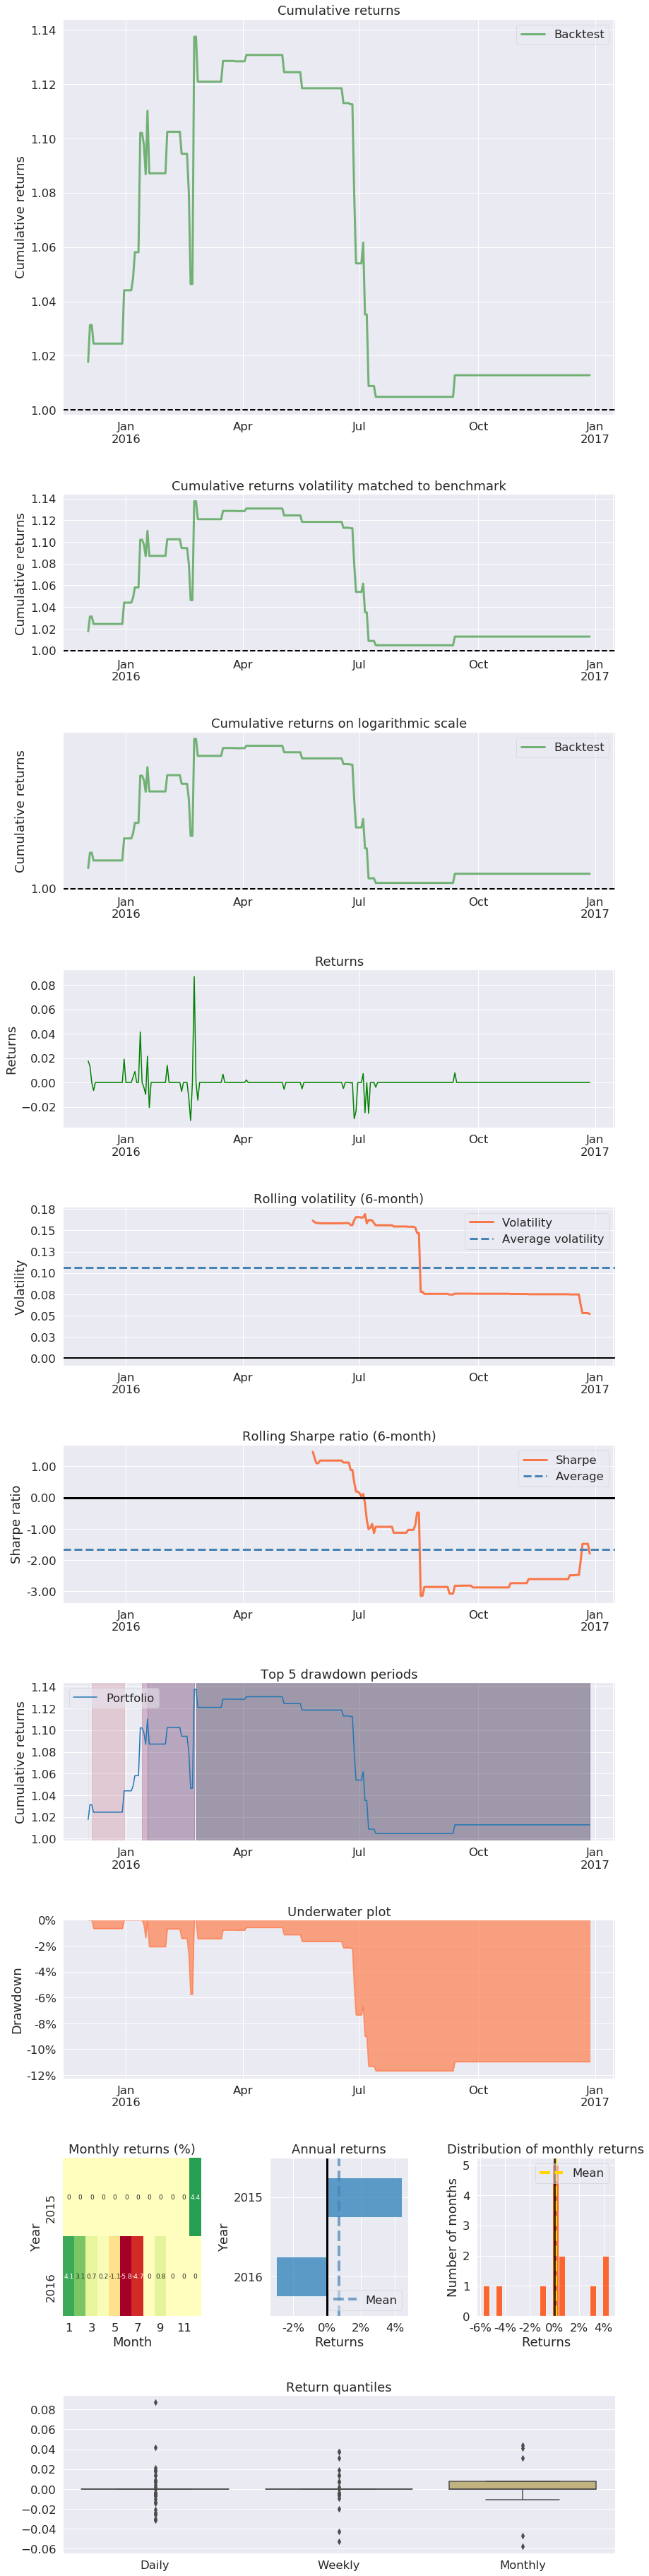

In [112]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

### For comparison we apply a Trend following strategy

# Fit a primary Model:Trend following


based on the simple cross-over strategy

In [48]:
#compute moving averages
fast_window=20
slow_window=50
data['fast_mavg']=data['close'].rolling(window=fast_window,min_periods=fast_window,center=False).mean()
data['slow_mavg']=data['close'].rolling(window=slow_window,min_periods=slow_window,center=False).mean()
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side,fast_mavg,slow_mavg
date_time,,,,,,,,,,,,,,
2015-01-02 15:43:25.099,2051.75,2051.75,2047.00,2047.75,34162,70005202.25,11490,2058.609174,2066.654918,2050.563430,21.0,1.0,NaN,NaN
2015-01-02 15:48:54.420,2047.75,2049.50,2045.50,2048.25,34192,70013855.25,11815,2057.749862,2066.623663,2048.876061,18.0,1.0,NaN,NaN
2015-01-02 15:57:26.907,2048.25,2051.75,2047.50,2050.50,34159,70006929.50,12459,2057.173673,2066.197362,2048.149984,31.0,1.0,NaN,NaN
2015-01-02 16:13:30.202,2045.50,2047.25,2041.75,2042.50,34458,70448431.00,11742,2055.266624,2066.280393,2044.252855,21.0,1.0,NaN,NaN
2015-01-02 16:22:57.951,2042.50,2045.50,2042.25,2043.25,34252,70009625.50,13140,2054.410942,2066.032026,2042.789859,21.0,1.0,NaN,NaN


In [49]:
#Compute sides
data['side']=np.nan
long_signals=data['fast_mavg']>=data['slow_mavg']
short_signals=data['slow_mavg']>data['fast_mavg']
data.loc[long_signals,'side']=1
data.loc[short_signals,'side']=-1
#Remove look ahead bias by lagging signal
data['side']=data['side'].shift(1)

In [50]:
# save the raw data
raw_data=data.copy()
#drop the nans
data.dropna(axis=0,how='any',inplace=True)

In [51]:
data['side'].value_counts()

 1.0    1190
-1.0    1096
Name: side, dtype: int64

# Filter events:Apply the CUSUM

Predict what will happen when the CUSUN event is triggered.We use the signal obtained from the moving averge strategy

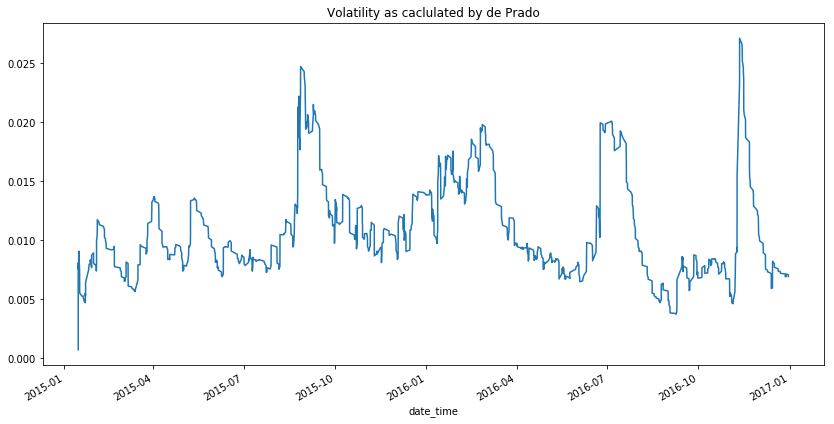

In [52]:
# Compute daily volatility
vol = ml.util.get_daily_vol(close=data['close'], lookback=50)
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=vol['2015-01-01':'2016-08-01'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)



Apply the tripple barrier method to the sampled features where ptsl=[1,1]

In [53]:
pt_sl = [1, 1]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

                                        

C:\ProgramData\Anaconda3\lib\site-packages\mlfinlab\labeling\labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-12-03 12:54:44.051833 100.0% apply_pt_sl_on_t1 done after 2.81 minutes. Remaining 0.0 minutes..


In [54]:
triple_barrier_events.tail()

,side,t1,trgt,pt,sl
2016-12-20 14:30:20.976,1.0,2016-12-22 14:43:03.713,0.007555,1,1
2016-12-22 14:43:03.713,1.0,2016-12-27 14:46:18.339,0.007341,1,1
2016-12-27 14:46:18.339,1.0,2016-12-28 17:13:53.327,0.007133,1,1
2016-12-28 17:13:53.327,1.0,2016-12-30 19:47:05.557,0.006934,1,1
2016-12-30 19:47:05.557,-1.0,NaT,0.007053,1,1


In [55]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])

In [56]:
labels.side.value_counts()

-1.0    220
 1.0    200
Name: side, dtype: int64

In [57]:
labels['bin'].value_counts()

0    327
1     93
Name: bin, dtype: int64

# Results of Primary Model:


We determine the accuracy of the primary mode i.e Precision,Recall and F1 scores

In [58]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       327
           1       0.22      1.00      0.36        93

   micro avg       0.22      0.22      0.22       420
   macro avg       0.11      0.50      0.18       420
weighted avg       0.05      0.22      0.08       420

Confusion Matrix
[[  0 327]
 [  0  93]]

Accuracy
0.22142857142857142


# Fit a Meta Model

Train a Random Forest Model to trade or not i.e 1 or 0 respectively with the earlier  model having decided the side(1,-1)

Create the following features
.

Volatility,Serial Correlation,The returns at the different lags from the serial correlation,The sides from SMAvg Strategy

In [59]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side,fast_mavg,slow_mavg
date_time,,,,,,,,,,,,,,
2015-01-02 15:43:25.099,2051.75,2051.75,2047.00,2047.75,34162,70005202.25,11490,2058.609174,2066.654918,2050.563430,21.0,NaN,NaN,NaN
2015-01-02 15:48:54.420,2047.75,2049.50,2045.50,2048.25,34192,70013855.25,11815,2057.749862,2066.623663,2048.876061,18.0,NaN,NaN,NaN
2015-01-02 15:57:26.907,2048.25,2051.75,2047.50,2050.50,34159,70006929.50,12459,2057.173673,2066.197362,2048.149984,31.0,NaN,NaN,NaN
2015-01-02 16:13:30.202,2045.50,2047.25,2041.75,2042.50,34458,70448431.00,11742,2055.266624,2066.280393,2044.252855,21.0,NaN,NaN,NaN
2015-01-02 16:22:57.951,2042.50,2045.50,2042.25,2043.25,34252,70009625.50,13140,2054.410942,2066.032026,2042.789859,21.0,NaN,NaN,NaN


In [60]:
raw_data['logret']=np.log(raw_data['close']).diff()

#momentum
raw_data['mom1']=raw_data['close'].pct_change(periods=1)
raw_data['mom2']=raw_data['close'].pct_change(periods=2)
raw_data['mom3']=raw_data['close'].pct_change(periods=3)
raw_data['mom4']=raw_data['close'].pct_change(periods=4)
raw_data['mom5']=raw_data['close'].pct_change(periods=5)

#volatility
raw_data['volatility_50']=raw_data['logret'].rolling(window=50,min_periods=50,center=False).std()
raw_data['volatility_30']=raw_data['logret'].rolling(window=30,min_periods=30,center=False).std()
raw_data['volatility_15']=raw_data['logret'].rolling(window=15,min_periods=15,center=False).std()
# Serial Correlation
window_autocorr=50
raw_data['autocorr_1'] = raw_data['logret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x:x.autocorr(lag=1),raw=False)
raw_data['autocorr_2'] = raw_data['logret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x:x.autocorr(lag=2),raw=False)
raw_data['autocorr_3'] = raw_data['logret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x:x.autocorr(lag=3),raw=False)
raw_data['autocorr_4'] = raw_data['logret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x:x.autocorr(lag=4),raw=False)
raw_data['autocorr_5'] = raw_data['logret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x:x.autocorr(lag=5),raw=False)
# Get the various log -t returns
raw_data['log_t1'] = raw_data['logret'].shift(1)
raw_data['log_t2'] = raw_data['logret'].shift(2)
raw_data['log_t3'] = raw_data['logret'].shift(3)
raw_data['log_t4'] = raw_data['logret'].shift(4)
raw_data['log_t5'] = raw_data['logret'].shift(5)

In [61]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [62]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [63]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [64]:
y.value_counts()

0    327
1     93
Name: bin, dtype: int64

In [93]:
#split data into training, validation and test sets
X_training_validation = X['2015-01-01':'2015-12-01']
y_training_validation = y['2015-01-01':'2015-12-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation,y_training_validation,test_size=0.15,shuffle=False)

In [94]:
train_df=pd.concat([y_train,X_train],axis=1,join='inner')
train_df['bin'].value_counts()

0    124
1     38
Name: bin, dtype: int64

In [95]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    124
0    124
Name: bin, dtype: int64

In [96]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [97]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [98]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.49271592 0.75117066 0.77744537 0.8074922  0.80983351 0.81373569
 0.81711759 0.57453174 0.77744537 0.82752341 0.8462539  0.85900104
 0.86472425 0.86472425 0.59170135 0.82310094 0.87096774 0.88007284
 0.88475546 0.89594173 0.89880333 0.61901665 0.82206035 0.88163371
 0.89438085 0.90790843 0.91050989 0.9128512  0.72073361 0.86888658
 0.91519251 0.91337149 0.91805411 0.92247659 0.92455775]
512 7 42


In [99]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       124

   micro avg       1.00      1.00      1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248

Confusion Matrix
[[124   0]
 [  0 124]]

Accuracy
1.0


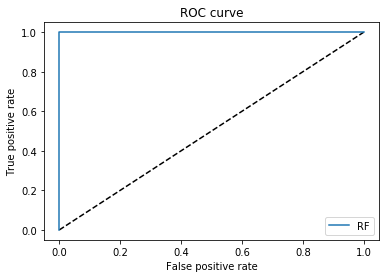

In [100]:
#Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.96      0.86        23
           1       0.00      0.00      0.00         6

   micro avg       0.76      0.76      0.76        29
   macro avg       0.39      0.48      0.43        29
weighted avg       0.62      0.76      0.68        29

Confusion Matrix
[[22  1]
 [ 6  0]]

Accuracy
0.7586206896551724


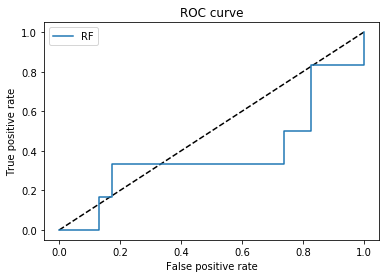

In [101]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [102]:
print(X_validate.index.min())
print(X_validate.index.max())

2015-10-13 15:22:53.452000
2015-12-01 14:48:02.414000


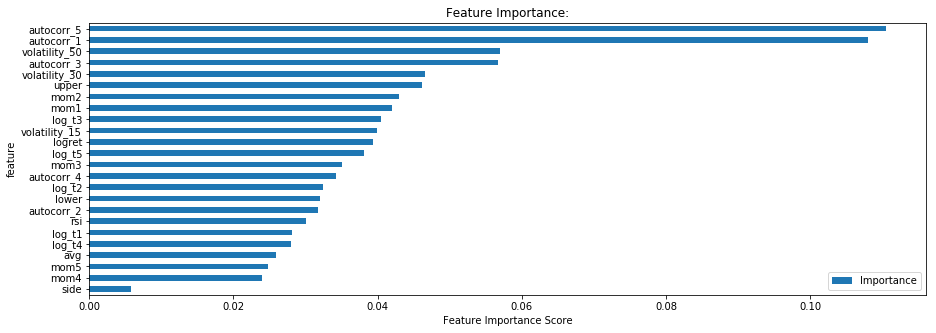

In [103]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheet(in sample)

In [104]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [105]:
valid_dates = X_validate.index


In [106]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [107]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [108]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")


perf_stats_df= pd.DataFrame(data=perf_stats_all, columns=['Meta Model'])

pf.show_perf_stats(daily_meta_rets)

Start date,2015-10-14
End date,2015-12-01
Total months,1
,Backtest
Annual return,-7.0%
Cumulative returns,-1.0%
Annual volatility,2.7%
Sharpe ratio,-2.68
Calmar ratio,-6.98
Stability,0.68
Max drawdown,-1.0%


# Perform Out of Sample test

Meta model Metrics

In [109]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2015-12-02':]
y_oos = y['2015-12-02':]

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       180
           1       0.23      0.20      0.22        49

   micro avg       0.69      0.69      0.69       229
   macro avg       0.51      0.51      0.51       229
weighted avg       0.67      0.69      0.68       229

Confusion Matrix
[[147  33]
 [ 39  10]]

Accuracy
0.6855895196506551


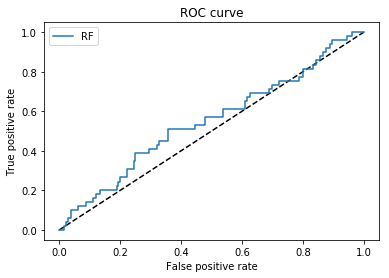

In [110]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Start date,2015-12-03
End date,2016-12-28
Total months,13
,Backtest
Annual return,1.2%
Cumulative returns,1.3%
Annual volatility,12.0%
Sharpe ratio,0.15
Calmar ratio,0.10
Stability,0.34
Max drawdown,-11.7%


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.66,2016-02-25,2016-07-14,NaT,NaN
1,5.75,2016-01-19,2016-02-22,2016-02-24,27
2,1.38,2016-01-14,2016-01-18,2016-01-19,4
3,0.66,2015-12-07,2015-12-08,2015-12-31,19
4,0.00,2015-12-03,2015-12-03,2015-12-03,1


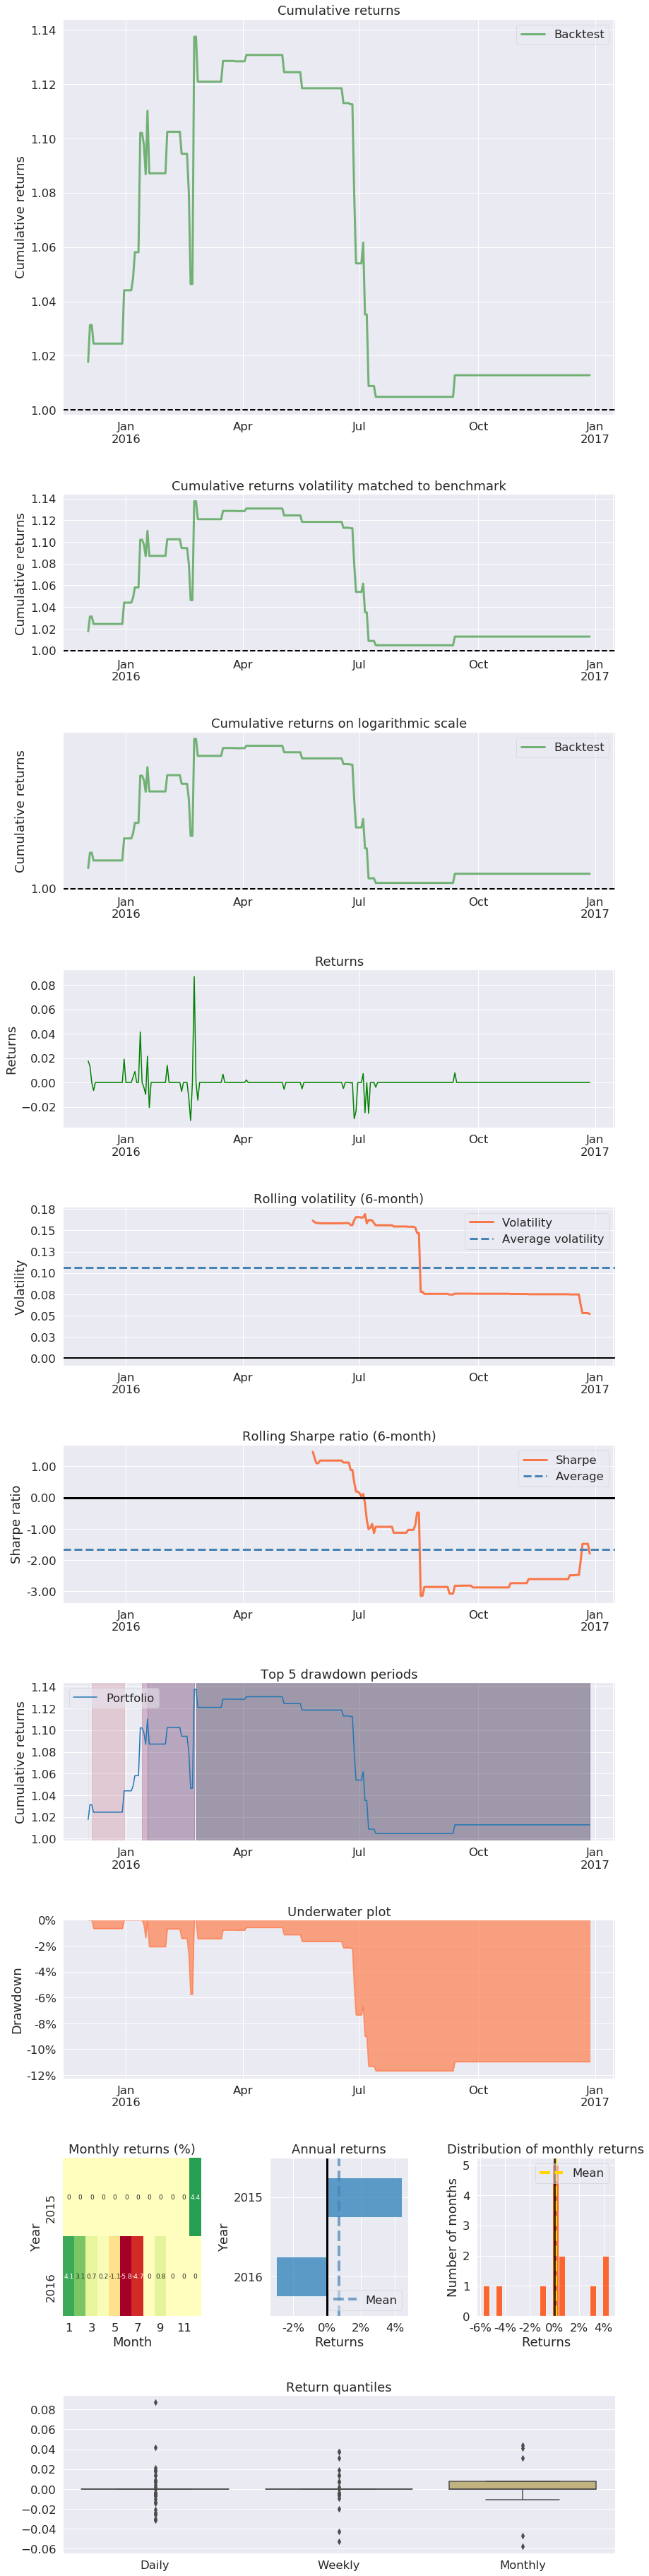

In [111]:
test_dates=X_oos.index
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

It can thereby be observed that the mean reverting strategies offer higher returns and sharpe ratios in contrast to trending strategies over the same dataset that was statistically proven to be mean reverting.This offers promise that indeed this strategy in conjuction with Dr Lopez de Prado's methods can offer portfolios with higher returns and sharpe ratios.